In [1]:
import pandas as pd
import numpy as np
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
bnb_df = pd.read_csv("./BNB Historical Data.csv")
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,601.80,593.80,608.19,593.20,161.02K,1.35%
1,05/31/2024,593.80,594.99,598.89,590.10,175.98K,-0.20%
2,05/30/2024,594.99,595.69,601.80,586.60,233.89K,-0.10%
3,05/29/2024,595.59,601.69,603.59,593.29,219.96K,-1.01%
4,05/28/2024,601.69,603.80,605.48,594.29,294.76K,-0.35%
...,...,...,...,...,...,...,...
1915,03/05/2019,13.65,11.40,13.74,11.40,8.34M,19.61%
1916,03/04/2019,11.41,11.45,11.51,10.88,2.74M,-0.29%
1917,03/03/2019,11.45,11.75,11.86,11.20,2.86M,-2.58%
1918,03/02/2019,11.75,11.35,11.80,10.83,3.89M,3.56%


### Pre-processing Data

In [3]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1920 non-null   object 
 1   Price     1920 non-null   float64
 2   Open      1920 non-null   float64
 3   High      1920 non-null   float64
 4   Low       1920 non-null   float64
 5   Vol.      1920 non-null   object 
 6   Change %  1920 non-null   object 
dtypes: float64(4), object(3)
memory usage: 105.1+ KB
None


* Định dạng lại cột `Date` để nó trở thành dạng `datetime`
* Xử lý và chuyển đổi kiểu dữ liệu của cột `Vol.` và `Change %` thành kiểu float

In [4]:
bnb_df['Date'] = pd.to_datetime(bnb_df['Date'])
bnb_df['Vol.'] = bnb_df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').fillna('0')
bnb_df['Vol.'] = bnb_df['Vol.'].astype(float)
bnb_df['Change %'] = bnb_df['Change %'].str.replace('%', '').astype(float)
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-06-01,601.80,593.80,608.19,593.20,161020.0,1.35
1,2024-05-31,593.80,594.99,598.89,590.10,175980.0,-0.20
2,2024-05-30,594.99,595.69,601.80,586.60,233890.0,-0.10
3,2024-05-29,595.59,601.69,603.59,593.29,219960.0,-1.01
4,2024-05-28,601.69,603.80,605.48,594.29,294760.0,-0.35
...,...,...,...,...,...,...,...
1915,2019-03-05,13.65,11.40,13.74,11.40,8340000.0,19.61
1916,2019-03-04,11.41,11.45,11.51,10.88,2740000.0,-0.29
1917,2019-03-03,11.45,11.75,11.86,11.20,2860000.0,-2.58
1918,2019-03-02,11.75,11.35,11.80,10.83,3890000.0,3.56


In [5]:
# Kiểm tra các giá trị thiếu
missing_values = bnb_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [6]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1920 non-null   datetime64[ns]
 1   Price     1920 non-null   float64       
 2   Open      1920 non-null   float64       
 3   High      1920 non-null   float64       
 4   Low       1920 non-null   float64       
 5   Vol.      1920 non-null   float64       
 6   Change %  1920 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 105.1 KB
None


In [7]:
# Mô tả dataset
sol_description = bnb_df.describe()
sol_description

,Date,Price,Open,High,Low,Vol.,Change %
count,1920,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,2021-10-15 12:00:00,229.552547,229.245161,235.806146,222.272714,4.316261e+06,0.329344
min,2019-03-01 00:00:00,9.250000,9.250000,10.410000,6.500000,8.993000e+04,-44.080000
25%,2020-06-22 18:00:00,27.030000,27.027500,27.807500,26.082500,5.633800e+05,-1.610000
50%,2021-10-15 12:00:00,247.550000,247.055000,254.285000,242.050000,1.600000e+06,0.130000
75%,2023-02-07 06:00:00,332.110000,331.345000,339.792500,322.325000,3.772500e+06,2.160000
max,2024-06-01 00:00:00,676.560000,676.250000,690.870000,634.810000,3.995400e+08,69.990000
std,NaN,184.430107,184.300217,189.692063,178.382323,2.135747e+07,4.891566


In [8]:
# Descriptive statistics for Price
print('More Price Statistics:')

print('Mode:', bnb_df['Price'].mode().values[0])
print('Standard Deviation:', bnb_df['Price'].std())
print('Variance:', bnb_df['Price'].var())
print('Kurtosis:', bnb_df['Price'].kurt())
print('Skewness:', bnb_df['Price'].skew())

More Price Statistics:
Mode: 23.01
Standard Deviation: 184.43010721388004
Variance: 34014.46444692328
Kurtosis: -0.8960616714167435
Skewness: 0.33018718587724444


##### Price by Date Plot

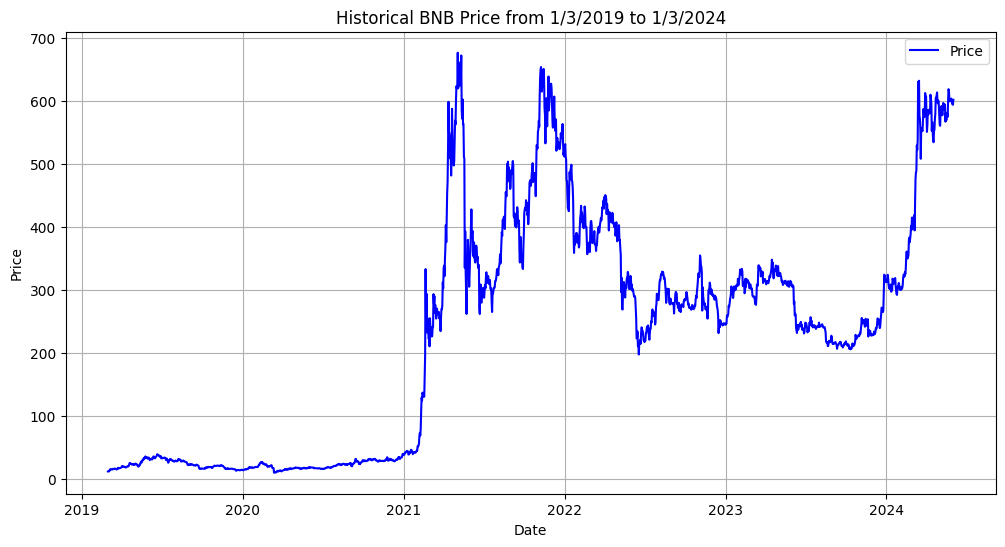

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(bnb_df['Date'], bnb_df['Price'], label='Price', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical BNB Price from 1/3/2019 to 1/3/2024')
plt.legend()
plt.grid(True)
plt.show()


##### Boxplot for Price

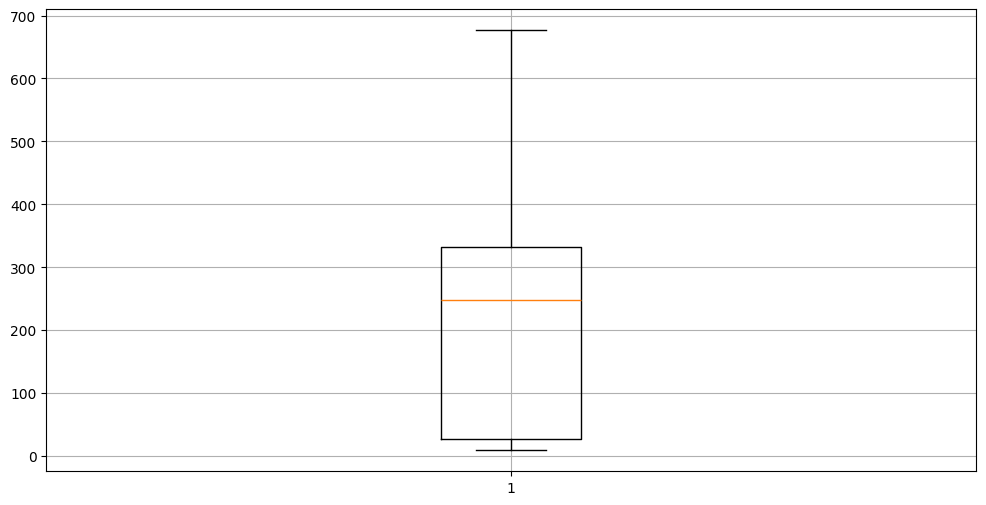

In [10]:
plt.figure(figsize=(12, 6))
plt.boxplot(bnb_df['Price'])
plt.grid()
plt.show()

### Model Training

##### Linear Regression

In [11]:
# Define features
features = ['Open', 'High', 'Low', 'Vol.', 'Change %']

# Define the target variable
target = 'Price'

In [12]:
# Split the data into training and testing sets
X = bnb_df[features]
y = bnb_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data count: {X_train.shape[0]}")
print(f"Testing data count: {X_test.shape[0]}")

Training data count: 1536
Testing data count: 384


In [13]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 20.819388990473914
R^2 Score: 0.5179209753956457
